# LAB3

In [21]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.linalg as sc

In [22]:
def mcol(v):
    return v.reshape((v.size, 1))

def load_iris(filename):

    hlabels = {
        'Iris-setosa': 0,
        'Iris-versicolor': 1,
        'Iris-virginica': 2 
    }

    datalist = []
    labellist = []

    with open(filename, 'r') as file:
        for line in file:
            line = line.split(",")
            name = line[-1].strip()
            label = hlabels[name]
            attrs = mcol(np.array([float(i) for i in line[:-1]]))
            datalist.append(attrs)
            labellist.append(label)

    return np.hstack(datalist), np.array(labellist, dtype=np.int32)

def plot_scatter(D, L):
    
    D0 = D[:, L==0]
    D1 = D[:, L==1]
    D2 = D[:, L==2]

    hFea = {
        0: 'Sepal length',
        1: 'Sepal width',
        2: 'Petal length',
        3: 'Petal width'
        }

    
    plt.figure()
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.scatter(D0[0, :], D0[1, :], label = 'Setosa')
    plt.scatter(D1[0, :], D1[1, :], label = 'Versicolor')
    plt.scatter(D2[0, :], D2[1, :], label = 'Virginica')

    plt.legend()
    plt.tight_layout() # Use with non-default font size to keep axis label inside the figure
    #plt.savefig(folder + '/scatter_%d_%d.pdf' % (dIdx1, dIdx2))
    plt.show()

In [23]:
D, L = load_iris('../data/iris.csv')

## PCA (Principal Component Analysis)

The PCA can be computed from  the eigenvectors of the data covariance matrix corresponding to the largest eigenvalues. The first step to implement PCA therefore requires computing the data covariance matrix.

$$ C = \dfrac{1}{N} \sum_{i=0}^{N} (x_i - \mu) (x_i- \mu)^T $$

where $ \mu $ is the dataset mean

$$ \mu = \dfrac{1}{N} \sum_{i=0}^{N} x_i  $$


In [24]:

mu = D.mean(axis=1)
mu = mu.reshape((mu.size, 1))
#center the data
DC = D - mu
mu


array([[5.84333333],
       [3.05733333],
       [3.758     ],
       [1.19933333]])


Compute the covariance matric **C** as:

$$C = \dfrac{1}{N} D_c D_C^T$$



In [25]:
C = np.dot(DC,DC.T) / float(DC.shape[1])
C

array([[ 0.68112222, -0.04215111,  1.26582   ,  0.51282889],
       [-0.04215111,  0.18871289, -0.32745867, -0.12082844],
       [ 1.26582   , -0.32745867,  3.09550267,  1.286972  ],
       [ 0.51282889, -0.12082844,  1.286972  ,  0.57713289]])

Once we have computed the data covariance matrix, we need to compute its eigenvectors and eigen-
values.

In [26]:
s, U = np.linalg.eigh(C)
s

array([0.02367619, 0.0776881 , 0.24105294, 4.20005343])

The m leading eigenvectors can be
retrieved from U (here we also reverse the order of the columns of U so that the leading eigenvectors are in the first m columns).


In [27]:
m = 2
P = U[:, ::-1][:, 0:m]
P

array([[-0.36138659,  0.65658877],
       [ 0.08452251,  0.73016143],
       [-0.85667061, -0.17337266],
       [-0.3582892 , -0.07548102]])

Since the covariance matrix is semi-denite positive, we can also get the sorted eigenvectors from the Singular Value Decomposition.

$$ C = U \Sigma V^T $$

In fatc, in this case $V^T = U^T $, thus $U \Sigma V^T = U \Sigma U^T$ is also an eigen-decomposition of $C$ 


In [28]:
U, s, Vh = np.linalg.svd(C)

In [29]:
P = U[:, 0:m]

Finally, we can apply the projection to a single point x or to a matrix of samples D as:

In [30]:
#y = np.dot(P.T, x)
DP = np.dot(P.T, DC)
DP.shape

(2, 150)

As we can se the classes present some zone where the point are overllapped

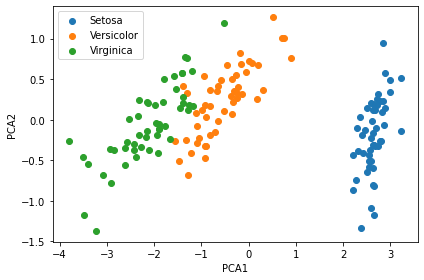

In [31]:
plot_scatter(DP, L)

## LDA (Linear Discriminant Analysis)

To compute the LDA transformation matrix W we need to compute the between and within class covariance matrices:


$$ S_B = \dfrac{1}{N} \sum_{c=1}^{K} (\mu_c - \mu) (\mu_c - \mu)^T $$
$$ S_W = \dfrac{1}{N} \sum_{c=1}^{K} \sum_{i=1}^{n_c} (x_c,i - \mu_c) (x_c,i - \mu_c)^T $$


The within class covariance matrix can be computed as a weighted sum the covariance matrices of each class:

$$ S_w = \dfrac{1}{N} \sum_{c=1}^{K} n_c S_w,c $$

where 

$$ S_W,c = \dfrac{1}{n_c} \sum_{i=1}^{n_c} (x_c,i - \mu_c) (x_c,i - \mu_c)^T $$


In [32]:
def vcol(vector, shape0):
    # Auxiliary function to transform 1-dim vectors to column vectors.
    return vector.reshape(shape0, 1)


def vrow(vector, shape1):
    # Auxiliary function to transform 1-dim vecotrs to row vectors.
    return vector.reshape(1, shape1)

In [33]:
np.unique(L).shape[0]

3

In [45]:
#compute S_B

 # Compute mean over columns of the dataset matrix
mu = D.mean(axis=1)
# Reshape the 1-D array mu to a column vector 4x1
mu = vcol(mu, mu.size)
# Compute classes means over columns of the dataset matrix
mu0 = D[:, L == 0].mean(axis=1)
mu1 = D[:, L == 1].mean(axis=1)
mu2 = D[:, L == 2].mean(axis=1)
# Reshape all of them as 4x1 column vectors
mu0 = vcol(mu0, mu0.size)
mu1 = vcol(mu1, mu1.size)
mu2 = vcol(mu2, mu2.size)
# Count number of elements in each class
n0 = D[:, L == 0].shape[1]
n1 = D[:, L == 1].shape[1]
n2 = D[:, L == 2].shape[1]
SB = (1/(n0+n1+n2))*((n0*np.dot(mu0-mu, (mu0-mu).T))+(n1*np.dot(mu1-mu, (mu1-mu).T)) +
                           (n2*np.dot(mu2-mu, (mu2-mu).T)))

((n0*np.dot(mu0-mu, (mu0-mu).T))+(n1*np.dot(mu1-mu, (mu1-mu).T)) +
                           (n2*np.dot(mu2-mu, (mu2-mu).T)))

array([[ 63.21213333, -19.95266667, 165.2484    ,  71.27933333],
       [-19.95266667,  11.34493333, -57.2396    , -22.93266667],
       [165.2484    , -57.2396    , 437.1028    , 186.774     ],
       [ 71.27933333, -22.93266667, 186.774     ,  80.41333333]])

In [35]:
#compute S_W
# Compute classes means over columns of the dataset matrix
mu0 = D[:, L == 0].mean(axis=1)
mu1 = D[:, L == 1].mean(axis=1)
mu2 = D[:, L == 2].mean(axis=1)
# Reshape all of them as 4x1 column vectors
mu0 = vcol(mu0, mu0.size)
mu1 = vcol(mu1, mu1.size)
mu2 = vcol(mu2, mu2.size)
# Count number of elements in each class
n0 = D[:, L == 0].shape[1]
n1 = D[:, L == 1].shape[1]
n2 = D[:, L == 2].shape[1]
# Compute within covariance matrix for each class
Sw0 = (1/n0)*np.dot(D[:, L == 0]-mu0, (D[:, L == 0]-mu0).T)
Sw1 = (1/n1)*np.dot(D[:, L == 1]-mu1, (D[:, L == 1]-mu1).T)
Sw2 = (1/n2)*np.dot(D[:, L == 2]-mu2, (D[:, L == 2]-mu2).T)
SW = (1/(n0+n1+n2))*(n0*Sw0+n1*Sw1+n2*Sw2)
SW

array([[0.259708  , 0.09086667, 0.164164  , 0.03763333],
       [0.09086667, 0.11308   , 0.05413867, 0.032056  ],
       [0.164164  , 0.05413867, 0.181484  , 0.041812  ],
       [0.03763333, 0.032056  , 0.041812  , 0.041044  ]])

Once we have computed the matrices, we need to find the solution to the LDA objective. We analyze two methods to compute the LDA directions


### Generalized eigenvalue problem


The LDA directions (columns of W ) can be computed solving the generalized eigenvalue problem

$$S_Bw = \lambda S_W w$$

In [36]:
s, U = sc.eigh(SB, SW)
W = U[:, ::-1][:, 0:m]
W


array([[ 0.83779794,  0.02434685],
       [ 1.55005187,  2.18649663],
       [-2.22355955, -0.94138258],
       [-2.83899363,  2.86801283]])

### Solving the eigenvalue problem by joint diagonalization of $S_B$ and $S_W$


We have seen that the LDA solution can be implemented as a first transformation that whitens thecwithin class covariance matrix, followed by a projection on the leading eigenvectors of the transformedcbetween class covariance.

The first step consists in estimating matrix $P_1$ such that the within class covariance of the transformed points $P_1x$ is the identity. Applying the transformation $P_1$ the covariance becomes $P_1S_wP_1^T$, thus we
can compute $P_1$ as:

$$P_1 = U\Sigma^\frac{-1}{2}U^T$$

where $U \Sigma U^T$ is the SVD of $S_W$. 


In [37]:
U, s, _ = np.linalg.svd(SW)

In [38]:
 # Compute P1 matrix
P1 = np.dot(np.dot(U, np.diag(1.0/(s**0.5))), U.T)

The transformed between class covariance S BT can be computed as:

$$S_{BT} = P_1 S_B P_1^T $$


In [39]:
 # Compute transformed SB
SBT = np.dot(np.dot(P1, SB), P1.T)

We finally need to compute the matrix $P_2$ of eigenvectors of $S_{BT}$ corresponding to its $m$ highest eigenvalues. The transformation from the original space to the LDA subspace can then be expressed
as $y = P_2^T P_1 x$. Thus, the LDA matrix $W$ is given by $W = P_1^T P_2$, and the LDA transformation is $y = W^T x$. Again, we can observe that the solution is not orthogonal.


In [61]:
# Get eigenvectors (columns of U ) from SBT
_, U = np.linalg.eigh(SBT)

# Compute P2 (m leading eigenvectors)
P2 = U[:, ::-1][:, 0:m]
# Compute W
W = np.dot(P1.T, P2)
# LDA projection matrix
DP = np.dot(W.T, D)
D

array([[5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
        4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
        5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
        5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
        6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
        6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
        6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
        6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3,
        6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5,
        7.7, 7.7, 6. , 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2,
        7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6. , 6.9, 6.7, 6.9, 5.8,
        6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9],
       [3.5, 3. , 3.2, 3.1, 3.6, 3.9, 3.4, 3.4, 2.9, 3.1, 3.7, 3.4, 3. ,
        3. , 4. , 4.4, 3.9, 3.5, 3.8, 3.8, 3.4, 3.7, 3.6, 3.3, 3.4, 3. ,
       

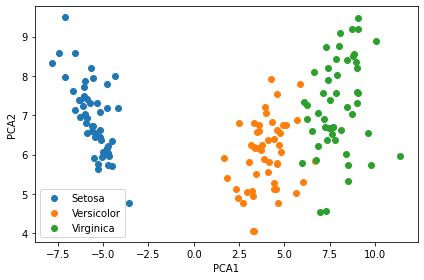

In [41]:
plot_scatter(DP, L)

In [51]:

solutionLDA = np.load('./solutions/IRIS_LDA_matrix_m2.npy')
np.linalg.svd(np.hstack([W, solutionLDA]))[1]


array([5.97718743e+00, 4.92713759e+00, 3.79904219e-14, 6.62911463e-16])

In [56]:
W

array([[-0.83779794,  0.02434685],
       [-1.55005187,  2.18649663],
       [ 2.22355955, -0.94138258],
       [ 2.83899363,  2.86801283]])